In [1]:
# importing libraries
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import datetime as dt 
from pathlib import Path

In [2]:
DATA_DIR = Path(r"C:\Users\nikik\citibike_tripdata\citibike-dashboard\2022-citibike-tripdata")

In [3]:
csv_files = list(DATA_DIR.rglob("*.csv"))
len(csv_files)

38

In [4]:
usecols = ["started_at","start_station_name","start_lat","start_lng","end_station_name","end_lat","end_lng","member_casual"]

TARGET_N = 150_000   
CHUNKSIZE = 200_000 
take_per_chunk = 1_000

samples = []
n = 0

for f in csv_files:
    for chunk in pd.read_csv(
        f,
        usecols=lambda c: c in usecols,
        chunksize=CHUNKSIZE,
        low_memory=False
    ):
        # drop rows missing start OR end station OR time
        chunk = chunk.dropna(subset=["start_station_name", "end_station_name", "started_at"])
        if chunk.empty:
            continue

        k = min(take_per_chunk, len(chunk), TARGET_N - n)
        if k <= 0:
            break

        samples.append(chunk.sample(n=k, random_state=42))
        n += k

        if n >= TARGET_N:
            break

    if n >= TARGET_N:
        break

bike_df = pd.concat(samples, ignore_index=True)

In [5]:
bike_df.shape

(150000, 8)

In [6]:
bike_df.to_csv("reduced_data_to_plot.csv", index=False)

In [7]:
list(DATA_DIR.glob("*weather*"))

[WindowsPath('C:/Users/nikik/citibike_tripdata/citibike-dashboard/2022-citibike-tripdata/citibike_2022_with_weather.csv'),
 WindowsPath('C:/Users/nikik/citibike_tripdata/citibike-dashboard/2022-citibike-tripdata/laguardia_weather_2022_tavg.csv')]

In [8]:
# reading weather data
weather_df = pd.read_csv(DATA_DIR / "laguardia_weather_2022_tavg.csv")

In [9]:
weather_df.head()

date  tavg_c            station
0  2022-01-01    11.6  GHCND:USW00014732
1  2022-01-02    11.4  GHCND:USW00014732
2  2022-01-03     1.4  GHCND:USW00014732
3  2022-01-04    -2.7  GHCND:USW00014732
4  2022-01-05     3.2  GHCND:USW00014732

In [10]:
df = pd.read_csv("reduced_data_to_plot.csv")

In [11]:
df.head()

started_at          start_station_name  \
0  2022-01-17 05:45:12.848    W 100 St & Manhattan Ave   
1  2022-01-14 12:52:57.277          E 67 St & Park Ave   
2  2022-01-10 17:08:24.611  Bergen St & Vanderbilt Ave   
3  2022-01-20 09:29:10.265             6 Ave & W 33 St   
4  2022-01-18 09:19:59.891            W 56 St & 10 Ave   

            end_station_name  start_lat  start_lng    end_lat    end_lng  \
0        Broadway & W 122 St  40.795000 -73.964500  40.812056 -73.961255   
1      E 59 St & Madison Ave  40.767801 -73.965921  40.763505 -73.971092   
2               4 Ave & 3 St  40.679439 -73.968044  40.673746 -73.985649   
3            W 15 St & 6 Ave  40.749013 -73.988484  40.738046 -73.996430   
4  Cathedral Pkwy & Broadway  40.768254 -73.988639  40.804213 -73.966991   

  member_casual  
0        member  
1        member  
2        casual  
3        member  
4        member

In [12]:
df.columns

Index(['started_at', 'start_station_name', 'end_station_name', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'member_casual'],
      dtype='object')

In [13]:
# most popular start stations in New York
df["value"] = 1

df_group = (
    df.groupby("start_station_name", as_index=False)
      .agg({"value": "sum"})
      .sort_values("value", ascending=False)
)

top20 = df_group.head(20)
top20

start_station_name  value
1540           W 21 St & 6 Ave    658
487         Broadway & W 58 St    647
1669     West St & Chambers St    630
8              1 Ave & E 68 St    545
283            6 Ave & W 33 St    544
455         Broadway & E 21 St    507
477         Broadway & W 25 St    498
453         Broadway & E 14 St    484
773            E 33 St & 1 Ave    474
579   Cleveland Pl & Spring St    474
1556           W 31 St & 7 Ave    468
552     Central Park S & 6 Ave    460
284            6 Ave & W 34 St    458
1670      West St & Liberty St    456
1466   University Pl & E 14 St    456
29            12 Ave & W 40 St    447
24            11 Ave & W 41 St    446
330            9 Ave & W 22 St    429
781         E 40 St & Park Ave    418
1085     Lafayette St & E 8 St    417

In [14]:
top20.to_csv("top20_nyc.csv", index=False)

In [15]:
import os
"top20_nyc.csv" in os.listdir()

True

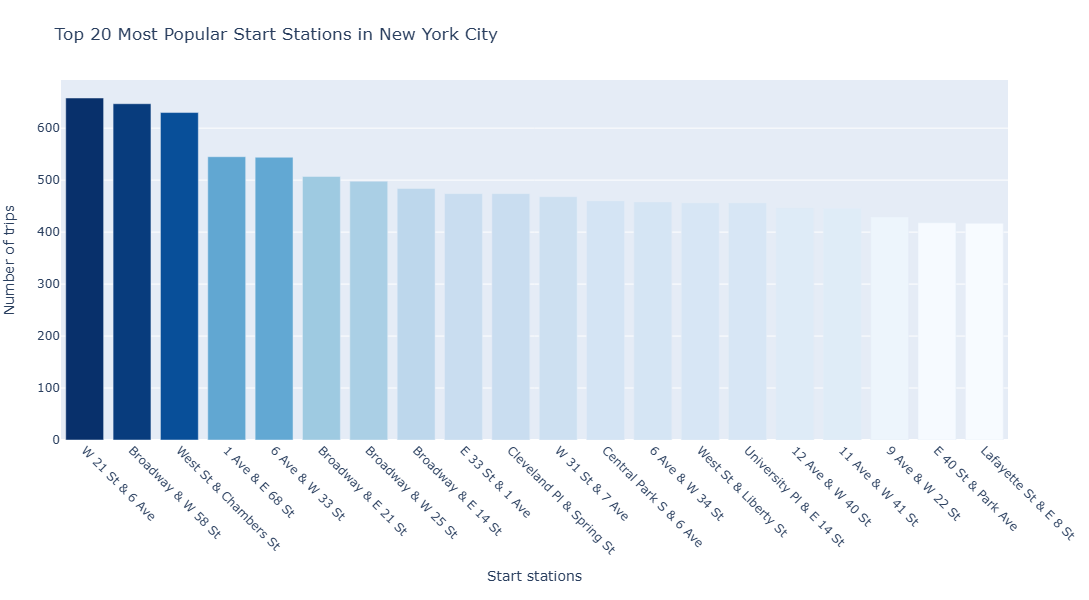

In [16]:
# plotting bar chart
fig = go.Figure(
    go.Bar(
        x=top20["start_station_name"],
        y=top20["value"],
        marker={"color": top20["value"], "colorscale": "Blues"},
        hovertemplate="Station: %{x}<br>Trips: %{y}<extra></extra>"
    )
)

fig.update_layout(
    title="Top 20 Most Popular Start Stations in New York City",
    xaxis_title="Start stations",
    yaxis_title="Number of trips",
    height=600,
    margin=dict(l=40, r=40, t=80, b=160)
)

fig.update_xaxes(tickangle=45)

fig.show()

In [17]:
bike_df["started_at"] = pd.to_datetime(bike_df["started_at"])

In [18]:
weather_df.columns

Index(['date', 'tavg_c', 'station'], dtype='object')

In [19]:
weather_df["date"] = pd.to_datetime(weather_df["date"])
weather_df = weather_df.rename(columns={"tavg_c": "avgTemp"})
weather_df = weather_df[["date", "avgTemp"]]

In [20]:
# aggregating bike data
daily_rides = (
    bike_df
    .groupby(bike_df["started_at"].dt.date)
    .size()
    .reset_index(name="bike_rides_daily")
)

daily_rides = daily_rides.rename(columns={"started_at": "date"})
daily_rides["date"] = pd.to_datetime(daily_rides["date"])

In [21]:
# merging weather and bike data
df_final = pd.merge(daily_rides, weather_df, on="date", how="inner")

In [22]:
df_final.head()

date  bike_rides_daily  avgTemp
0 2022-01-01               102     11.6
1 2022-01-02               233     11.4
2 2022-01-03               182      1.4
3 2022-01-04               181     -2.7
4 2022-01-05               167      3.2

In [23]:
df_final.shape

(365, 3)

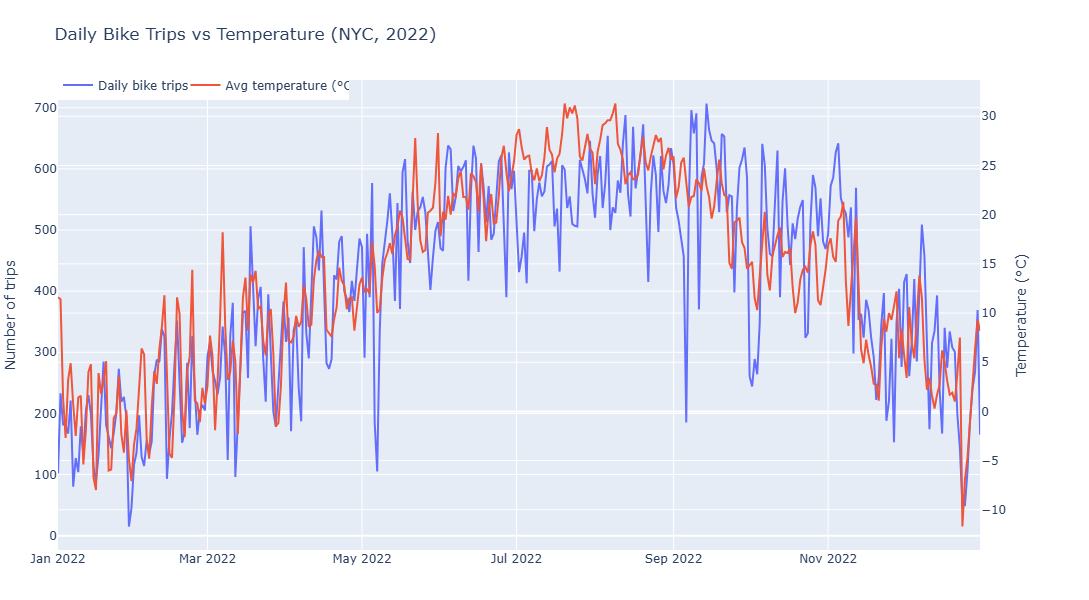

In [24]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Trips line (primary y-axis)
fig.add_trace(
    go.Scatter(
        x=df_final["date"],
        y=df_final["bike_rides_daily"],
        name="Daily bike trips",
        mode="lines",
        hovertemplate="Date: %{x|%Y-%m-%d}<br>Trips: %{y}<extra></extra>"
    ),
    secondary_y=False
)

# Temperature line (secondary y-axis)
fig.add_trace(
    go.Scatter(
        x=df_final["date"],
        y=df_final["avgTemp"],
        name="Avg temperature (°C)",
        mode="lines",
        hovertemplate="Date: %{x|%Y-%m-%d}<br>Temp: %{y:.1f} °C<extra></extra>"
    ),
    secondary_y=True
)

fig.update_layout(
    title="Daily Bike Trips vs Temperature (NYC, 2022)",
    height=600,
    margin=dict(l=50, r=50, t=80, b=50),
    legend=dict(orientation="h", y=1.02, x=0)
)

fig.update_yaxes(title_text="Number of trips", secondary_y=False)
fig.update_yaxes(title_text="Temperature (°C)", secondary_y=True)

fig.show()

In [25]:
df_final.to_csv("reduced_data_to_plot_merged.csv", index=False)

In [26]:
bike_df.columns

Index(['started_at', 'start_station_name', 'end_station_name', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'member_casual'],
      dtype='object')